In [1]:
import pandas as pd
import sys;sys.path.append('..')
import warnings; warnings.simplefilter("ignore")
from surprise import SVD, Reader, Dataset
from collections import defaultdict
import numpy as np

df = pd.read_csv('../data/explicit_usa.csv')
df = df.drop("Unnamed: 0", axis=1)
df.head()

,User-ID,ISBN,Book-Rating,Age,city,state,country,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,2954,0060973129,8.0,71.0,wichita,kansas,usa,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
1,35704,0374157065,6.0,53.0,kansas city,missouri,usa,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
2,110912,0374157065,10.0,36.0,milpitas,california,usa,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
3,157969,0374157065,8.0,30.0,denver,colorado,usa,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,192665,0374157065,8.0,47.0,vacaville,california,usa,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...


In [36]:
import joblib
train_df, test_df = joblib.load("../data/train_test_split.pkl")

In [37]:
train_user_ids = train_df["User-ID"].unique()
train_book_ids = train_df["ISBN"].unique()


In [38]:
test_df = test_df[test_df["User-ID"].isin(train_user_ids)]
test_df = test_df[test_df["ISBN"].isin(train_book_ids)]


In [39]:
print(f"trainデータサイズ：　{len(train_df)}")
print(f"testデータサイズ：　{len(test_df)}")

trainデータサイズ：　17180
testデータサイズ：　1562


In [71]:
# train, testデータで観測構造が違う状況を作る。
dummy_rating = np.random.randint(1, 11, len(test_df))
test_df["Book-Rating"] = dummy_rating


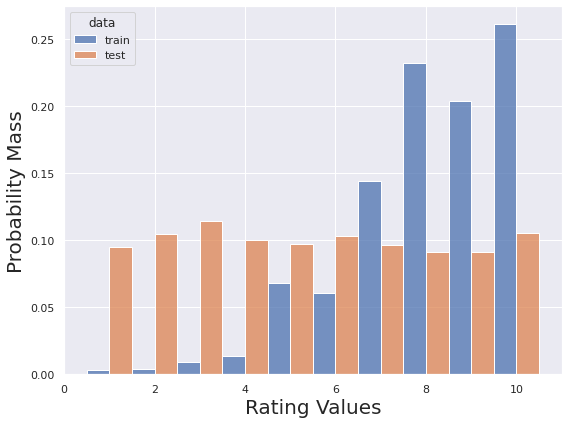

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

train_df["data"] = "train"
test_df["data"] = "test"
data_df = pd.concat([train_df, test_df])

plt.subplots(1, figsize=(8,6))
sns.histplot(
    data_df, 
    x="Book-Rating",  
    stat="probability", 
    discrete=True,
    hue="data",
    multiple="dodge",
    common_norm=False,
)

plt.xlabel('Rating Values', fontdict=dict(size=20))
plt.ylabel('Probability Mass', fontdict=dict(size=20))
plt.tight_layout()
plt.show()

In [82]:
# 少量の完全ランダムな嗜好度合いデータを用いて傾向スコアを推定する [Schnbel16]
numerator = np.unique(train_df["Book-Rating"].values, return_counts=True)[1]
numerator = numerator / numerator.sum() #P(R=r|O=1)の推定
denominator = np.unique(test_df["Book-Rating"].values, return_counts=True)[1]
denominator = denominator / denominator.sum() #(擬似的に作った真の) P(R=r)
numerator / denominator

array([0.03194475, 0.04071863, 0.07923726, 0.13377353, 0.70223485,
       0.58617777, 1.49144392, 2.53557804, 2.22530671, 2.47466822])

In [45]:
from sklearn.metrics import mean_squared_error
from surprise.model_selection import cross_validate

class MF:
    def __init__(self, train_df, test_df):
        reader = Reader(rating_scale=(1, 10))
        self.data_train = Dataset.load_from_df(
            train_df[["User-ID", "ISBN", "Book-Rating"]], reader
        )
        self.test_df = test_df
    
    def cross_validation(self, **kwargs):
        self.n_factors = kwargs.get("n_factors", 200)
        self.lr_all = kwargs.get("lr_all", 0.005)
        self.n_epochs = kwargs.get('n_epochs', 200)
        self.reg_all = kwargs.get('reg_all', 0.4)
        
        self.mf = SVD(
            n_factors=self.n_factors,
            lr_all=self.lr_all,
            n_epochs=self.n_epochs,
            reg_all=self.reg_all
        )
        
        result = cross_validate(self.mf, self.data_train, measures=["rmse"], cv=5, n_jobs=-1)
        val_score = result["test_rmse"].mean()
        return val_score
    
    def test(self):
        full_data = self.data_train.build_full_trainset()
        model = self.mf.fit(full_data)
        predictions = model.test(full_data.build_anti_testset(None))
        
        test_data = pd.DataFrame.from_dict(
            [{"User-ID": p.uid, "ISBN": p.iid, "rating_pred": p.est}
                for p in predictions
            ]
        )
        book_rating_predict = self.test_df.merge(test_data, on=["User-ID", "ISBN"])
        
        test_score = self._calc_rmse(
            book_rating_predict["Book-Rating"].to_list(),
            book_rating_predict["rating_pred"].to_list()
        )
        
        return test_score
     
    def _calc_rmse(self, true_rating, pred_rating):
        return np.sqrt(mean_squared_error(true_rating, pred_rating))
        
        
        
    

In [46]:
mf = MF(train_df, test_df)

In [47]:
val_score = mf.cross_validation()

In [49]:
print(f"validation RMSE = {val_score:.3}")

validation RMSE = 1.51


In [50]:
test_score = mf.test()

In [51]:
print(f"test RMSE = {test_score:.3}")

test RMSE = 1.61
